In [119]:
import numpy as np
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self-signed certificate in certificate chain
[nltk_data]     (_ssl.c:1000)>


In [120]:
with open("input.txt") as file:
    data = file.read()
print(data[:100])

O for a Muse of fire, that would ascend
The brightest heaven of invention,
A kingdom for a stage, pr


In [122]:
sorted(set(list(data)))

['\n',
 ' ',
 '!',
 '"',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '>',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [123]:
import re

data = re.sub(r'!"(),-:;<>?', '.', data)
data = word_tokenize(data)
data = [word.lower() for word in data if word.isalpha() or word == '.']
data = list(set(data))

print(len(data))

5774


In [124]:
word2ind = {word: i for i, word in enumerate(data)}
ind2word = {i: word for i, word in enumerate(data)}

In [125]:
V = len(word2ind)
print(f'Vocabulary size: {V}')

Vocabulary size: 5774


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim

class CBOW(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CBOW, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
        # no need of softmax since cross entropy loss does it internally

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [127]:
def get_data(words_data, context_size):
    input_data = []
    for i in range(context_size, len(words_data) - context_size):
        target = words_data[i]
        context = []
        for j in range(i-context_size, i):
            context.append(words_data[j])
        for j in range(i+1, i+context_size+1):
            context.append(words_data[j])
        input_data.append((context, target))
    return input_data

In [128]:
def convert_to_ids(words_data, context_size):
    input_data = get_data(words_data, context_size)
    
    train_data = []
    target_data = []

    for context, target in input_data:
        train_tensor = torch.zeros(V)
        target_tensor = torch.zeros(1, dtype=torch.long) # assigned as a single vector and not one hot

        for word in context:
            train_tensor[word2ind[word]] += 1
        target_tensor[0] = word2ind[target] # assign the index of the target word

        train_tensor = train_tensor.view(1, -1)
        
        yield train_tensor, target_tensor

In [129]:
for train_tensor, target_tensor in convert_to_ids(data[:7], 2):
    print(train_tensor)
    print(target_tensor)

tensor([[1., 1., 0.,  ..., 0., 0., 0.]])
tensor([2])
tensor([[0., 1., 1.,  ..., 0., 0., 0.]])
tensor([3])
tensor([[0., 0., 1.,  ..., 0., 0., 0.]])
tensor([4])


In [136]:
hidden_dim = 5

model = CBOW(V, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [137]:
epochs = 1020

epoch_losses = {}

for epoch in range(epochs):
    
    losses = []
    
    for X, y in convert_to_ids(data, 2):
        outputs = model(X)
        loss = criterion(outputs, y)
        losses.append(loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_losses[epoch] = np.mean(losses)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, loss: {loss.item():.4f}')

Epoch 10, loss: 8.5310
Epoch 20, loss: 8.3457
Epoch 30, loss: 8.1103
Epoch 40, loss: 7.8061
Epoch 50, loss: 7.4410
Epoch 60, loss: 7.0529
Epoch 70, loss: 6.6780
Epoch 80, loss: 6.3270
Epoch 90, loss: 6.0022
Epoch 100, loss: 5.7072
Epoch 110, loss: 5.4424
Epoch 120, loss: 5.2048
Epoch 130, loss: 4.9900
Epoch 140, loss: 4.7948
Epoch 150, loss: 4.6162
Epoch 160, loss: 4.4518
Epoch 170, loss: 4.2997
Epoch 180, loss: 4.1586
Epoch 190, loss: 4.0271
Epoch 200, loss: 3.9044
Epoch 210, loss: 3.7896
Epoch 220, loss: 3.6821
Epoch 230, loss: 3.5812
Epoch 240, loss: 3.4865
Epoch 250, loss: 3.3975
Epoch 260, loss: 3.3141
Epoch 270, loss: 3.2359
Epoch 280, loss: 3.1625
Epoch 290, loss: 3.0937
Epoch 300, loss: 3.0290
Epoch 310, loss: 2.9683
Epoch 320, loss: 2.9110
Epoch 330, loss: 2.8570
Epoch 340, loss: 2.8057
Epoch 350, loss: 2.7570
Epoch 360, loss: 2.7106
Epoch 370, loss: 2.6661
Epoch 380, loss: 2.6233
Epoch 390, loss: 2.5820
Epoch 400, loss: 2.5421
Epoch 410, loss: 2.5034
Epoch 420, loss: 2.4658
E

KeyboardInterrupt: 

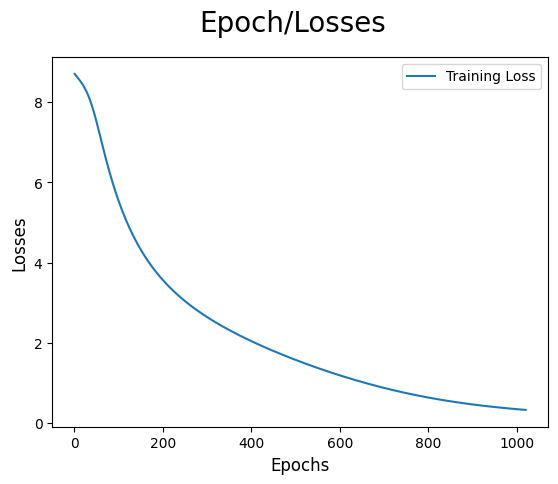

In [138]:
import matplotlib.pyplot as plt

epochs_range = np.arange(1, 1020 + 1)
loss_values = [epoch_losses[e] for e in epochs_range - 1]

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(epochs_range, loss_values, label="Training Loss")
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)
plt.legend()

In [142]:
print('Learned weights from the CBOW model:\n')

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Learned weights from the CBOW model:

linear1.weight 	 torch.Size([5, 5774])
linear2.weight 	 torch.Size([5774, 5])
linear2.bias 	 torch.Size([5774])


In [143]:
print("Optimizer's state_dict:\n")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:

state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1, 2]}]


In [144]:
torch.save(model.state_dict(), 'cbow.pth')